Files were obtained from: https://www.slac.stanford.edu/~behroozi/MultiDark_Hlists_Rockstar/

In [1]:
import numpy as np
import astropy
from astropy.table import Table 
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# pandas example. 

In [3]:
#import pandas as pd
# cat = pd.read_table("catalogues/hlist_0.07835.txt", header=0, comment='#', sep='\s+', engine='python')

# Astropy table 

In [4]:
#read the one at redshift z = 0. 
cat = Table.read("../data/hlist_0.11515.list.gz", format="ascii")
#cat = Table.read("catalogues/hlist_1.00035.list.gz", format="ascii")
new_names = [name[:name.rfind('(')] for name in cat.colnames]
for name, new_name in zip(cat.colnames, new_names): 
    cat.rename_column(name, new_name)

In [5]:
print(cat.colnames)

['scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid', 'phantom', 'sam_mvir', 'mvir', 'rvir', 'rs', 'vrms', 'mmp?', 'scale_of_last_MM', 'vmax', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'Spin', 'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'Orig_halo_ID', 'Snap_num', 'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Last_mainleaf_depthfirst_ID', 'Rs_Klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Macc', 'Mpeak', 'Vacc', 'Vpeak', 'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn', 'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'Mpeak_Scale', 'Acc_Scale', 'First_Acc_Scale', 'First_Acc_Mvir', 'First_Acc_Vmax', 'Vmax@Mpeak']


In [6]:
# add some of the missing parameters. 
# c_vir, phi_L, shape q
#some phi_L have NaNs 
cvir = cat['rvir'] / cat['rs']
phi_l = np.arccos(
    ((cat['A[x]']*cat['Jx'] + cat['A[y]']*cat['Jy'] + cat['A[z]']*cat['Jz'])
     /
    (np.sqrt(cat['A[x]']**2 + cat['A[y]']**2 + cat['A[z]']**2)*np.sqrt(cat['Jx']**2 + cat['Jy']**2 + cat['Jz']**2) )
    )
)
q = (1/2)*(cat['b_to_a'] + cat['c_to_a']);

In [7]:
#now we add these columns to our table. 
cat.add_column(cvir, name='cvir')
cat.add_column(phi_l, name='phi_l')
cat.add_column(q, name='q')

In [8]:
print("length of catalogue:", len(cat))
print("Number of nan:", sum(np.isnan(cat['phi_l'])))

#We can ignore the 'nan's from Phi_L too for simplicity. 
cat = cat[~np.isnan(cat['phi_l'])]

print("final length of catalogue:", len(cat))

length of catalogue: 29282
Number of nan: 3431
final length of catalogue: 25851


# Spearman correlation example

In [9]:
#variables we care about for computing correlations 
params = ['mvir', 'cvir' , 'T/|U|', 'Xoff', 'Voff', 'Spin', 'q', 'phi_l',
         #rho_rms
         ]

In [51]:
print("Spearman correlation coefficient between parameters...")
for i, param1 in enumerate(params): 
    for param2 in params[i+1:]:
        corr, p = spearmanr(cat[param1], cat[param2])
        print(f"{param1}, {param2}: {corr, p}")
        

Spearman correlation coefficient between parameters...
mvir, rvir: (0.99992233232189, 0.0)
mvir, rs: (0.4022782248228001, 0.0)
mvir, T/|U|: (0.0437461296039327, 3.1547700357432375e-26)
mvir, Xoff: (-0.4685466287731245, 0.0)
mvir, Voff: (-0.3314983767232904, 0.0)
mvir, Spin: (-0.049877943823250045, 1.3239086903037653e-33)
rvir, rs: (0.40255167566098465, 0.0)
rvir, T/|U|: (0.04388142780906145, 2.2207556064329223e-26)
rvir, Xoff: (-0.4686043068523951, 0.0)
rvir, Voff: (-0.3318313673301552, 0.0)
rvir, Spin: (-0.04997467157168447, 9.949972195116539e-34)
rs, T/|U|: (0.3856976027944693, 0.0)
rs, Xoff: (0.046720559816148144, 1.0961327223833405e-29)
rs, Voff: (0.22754727528110552, 0.0)
rs, Spin: (0.08118099652054181, 2.9622445333130015e-86)
T/|U|, Xoff: (0.15369405107279177, 1.41315581926802e-306)
T/|U|, Voff: (0.23813866439101575, 0.0)
T/|U|, Spin: (0.10990648696205141, 6.870649827641693e-157)
Xoff, Voff: (0.29200364193873357, 0.0)
Xoff, Spin: (-0.025747509621701952, 4.555086730303204e-10)
Vof

In [10]:
#prettier version. 
corrs = np.zeros((len(params), len(params)))
for i,param1 in enumerate(params): 
    for j,param2 in enumerate(params):
        corr, p = spearmanr(cat[param1], cat[param2])
        corrs[i,j] = corr


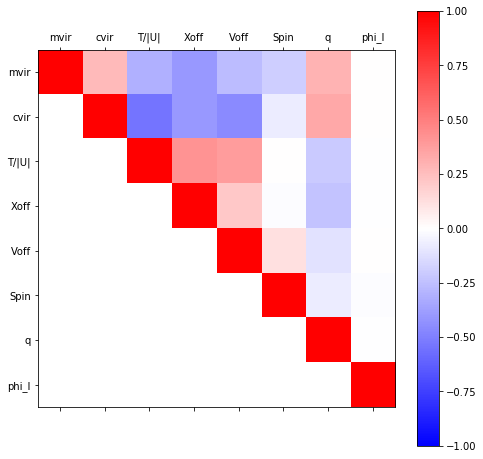

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
mask =  np.tri(corrs.shape[0], k=-1)
A = np.ma.array(corrs, mask=mask)
im = ax.matshow(A,cmap='bwr',vmin=-1, vmax=1)
plt.colorbar(im, ax = ax)
ax.set_xticklabels(['']+params);
ax.set_yticklabels(['']+params);

# Correlation between Mvir vs. Xoff , rho_rms

Draw contour plots to illustrate the correlation between `Xoff` and `rho_rms` with respect to Mvir

## mass and rho_rms

In [9]:
# plt.scatter(cat['mvir'], cat['rho_rms'])
# plt.xscale('log')
# plt.yscale('log')

## mass and xoff 

**Question**: How to resolve this ambiguity? 

correlation: -0.40525257836434747


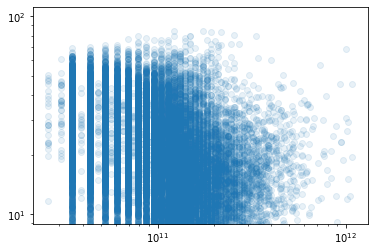

In [10]:
#all masses in catalogue
plt.scatter(cat['mvir'], cat['Xoff'], alpha=0.1)
plt.xscale('log')
plt.yscale('log')
print("correlation:", spearmanr(cat['mvir'], cat['Xoff'])[0])

We also plot **contours**: 

In [15]:
from astroML.plotting import scatter_contour

([<matplotlib.lines.Line2D at 0x2b45e2e4aef0>],
 <matplotlib.contour.QuadContourSet at 0x2b45e24fe6d8>)

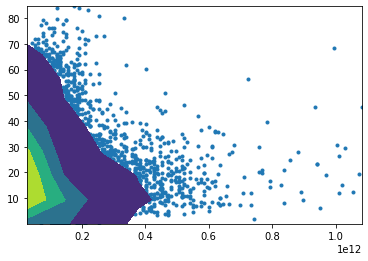

In [25]:
scatter_contour(cat['mvir'], cat['Xoff'], filled_contour=True, threshold=100, levels=5)

# Histograms of the variables

## halo masses 

Divide into relaxed/unrelaxed and different Mpc box (90, 180) 

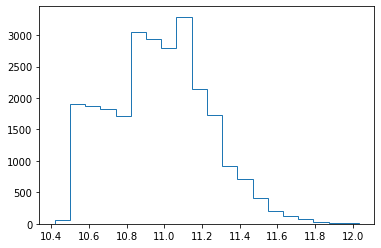

In [31]:

plt.hist(np.log10(cat['mvir']), bins=20, histtype='step');

The figure in the paper uses a 90Mpc box and only halos with more than 100 particles and log(mvir)~12

In [20]:
params = ['cvir', 'Spin', 'q', 'phi_l', 'Xoff', 'T/|U|'
         ]

mean, median, and std of:
cvir: 0.958934315992413 0.9743081309658334 0.20868951484019552
Spin: -1.6269076713205923 -1.5967079904325236 0.23829748521246844
q: -0.2699736791425284 -0.22399502836418947 0.18870052249825733
phi_l: 0.16392762476438608 0.20266895555505499 0.20486419990107754
Xoff: 1.174660037797183 1.1990971209289172 0.24593769974948435
T/|U|: -0.24065576735171818 -0.24142871755148493 0.04871275514191122


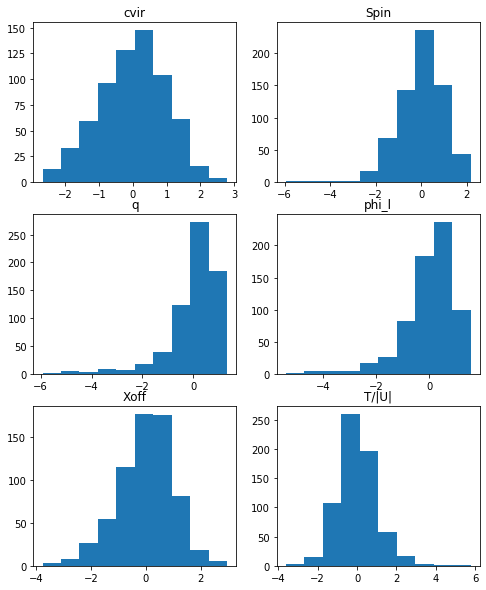

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(8,10))
cat12 = cat[ (11.5< np.log10(cat['mvir'])) & (np.log10(cat['mvir'])< 12.5) & (cat['q']!=0)]
print('mean, median, and std of:')
for param, ax in zip(params, axs.flatten()): 
    x = np.log10(cat12[param]) 
    px = (x - np.mean(x))/ np.std(x)
    ax.set_title(param)
    ax.hist(px)
    print(f'{param}:', np.mean(x), np.median(x), np.std(x))

# PCA 


## mass threshold

In [37]:
from sklearn.decomposition import PCA

In [38]:
params = ['mvir', 'cvir','Spin', 'q','phi_l', 'Xoff', 'T/|U|'
         ]

In [39]:
pca = PCA(n_components=4)

In [ ]:
def remove_outliers(x, p=0.95): 
    return x[x < ]

In [59]:
#normalize and take log.
#cuts on mass >= 12 once we get z= 0 catalogue and different fixed mass regimes too.  
# remove extreme outliers too. 
cat12 = cat[(cat['q']!=0) &(cat['Spin']!=0)]
X = np.zeros((len(params), len(cat12['mvir'])))
for i, param in enumerate(params): 
    x = np.log10(cat12[param])
    px = (x - np.mean(x))/ np.std(x)
    px 
    X[i] = px 
    

In [79]:
X.shape

(7, 25435)

In [80]:
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [86]:
np.set_printoptions(threshold=50)
print(params)
print(pca.singular_values_)
print(pca.explained_variance_ratio_)  
print(pca.components_)

['mvir', 'cvir', 'Spin', 'q', 'phi_l', 'Xoff', 'T/|U|']
[236.16142825 163.97727744 158.72515756 150.4155057 ]
[0.31324789 0.15102108 0.14150173 0.12707363]
[[ 0.43379672  0.50657951 -0.1479911   0.3325711  -0.00144983 -0.42516717
  -0.49185718]
 [ 0.25328736 -0.14232483 -0.79011359  0.11303459 -0.41248775  0.30196931
   0.13115351]
 [-0.1406827   0.06796865  0.38064695  0.07731636 -0.90178702 -0.10470169
  -0.02316155]
 [-0.01752268  0.00649422 -0.21055613 -0.87796209 -0.1257012  -0.2277909
  -0.34177476]]


In [93]:
pca.components_[0]**2

array([1.88179594e-01, 2.56622796e-01, 2.19013650e-02, 1.10603535e-01,
       2.10202068e-06, 1.80767124e-01, 2.41923485e-01])

In [90]:
0.5**2 + 0.5**2 + 0.5**2

0.75

## fixed mass

In [ ]:
# paper uses 12, 13.3, 13.6 